# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
conda update pandas

Solving environment: ...working... 

Updating pandas is constricted by 

anaconda -> requires pandas==1.1.3=py38ha925a31_0

If you are sure you want an update of your package either try `conda update --all` or install a specific version of the package you want using `conda install <pkg>=<version>`

done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
%matplotlib inline

In [3]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [4]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [5]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [6]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [7]:
print(portfolio.shape)
print(profile.shape)
print(transcript.shape)

(10, 6)
(17000, 5)
(306534, 4)


# Data Preparation

__Portfolio Dataset__

In [8]:
channels_set = set()
for i in portfolio.channels:
    channels_set.update(set(i))

In [9]:
#make dummy variables from channels 
for i in channels_set:
    portfolio[i] = portfolio.channels.apply(lambda x: i in x).map({True:1, False: 0})
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id,social,web,email,mobile
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,0,1,1
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,0,1,1,1
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,1,1
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,1,0


In [10]:
portfolio.drop('channels',axis=1, inplace = True)

In [11]:
portfolio.isna().sum()

reward        0
difficulty    0
duration      0
offer_type    0
id            0
social        0
web           0
email         0
mobile        0
dtype: int64

__Profile Dataset__

In [12]:
profile.isna().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

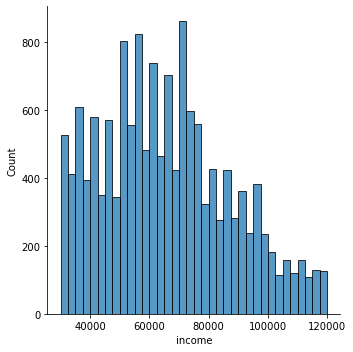

In [13]:
#distribution of income of Starbucks customers
sns.displot(profile.income)

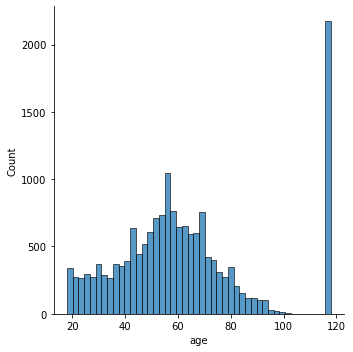

In [14]:
sns.displot(profile.age)

In [15]:
#let's look at the anomaly. They are all 
profile[profile['age']>110]['age'].value_counts()

118    2175
Name: age, dtype: int64

In [16]:
#percentage of values are 118 yo
profile[profile['age']>110]['age'].value_counts()/profile.shape[0]*100

118    12.794118
Name: age, dtype: float64

In [17]:
#12 percent of the data is age 118. This is clearly incorrect data.
profile['age'].replace(118,np.nan, inplace = True)
profile.dropna(subset=['age'], inplace = True)

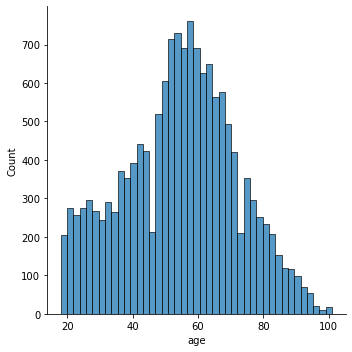

In [18]:
sns.displot(profile.age)

In [19]:
profile['age']

1        55.0
3        75.0
5        68.0
8        65.0
12       58.0
         ... 
16995    45.0
16996    61.0
16997    49.0
16998    83.0
16999    62.0
Name: age, Length: 14825, dtype: float64

In [20]:
profile.shape

(14825, 5)

In [21]:
profile

,gender,age,id,became_member_on,income
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
5,M,68.0,e2127556f4f64592b11af22de27a7932,20180426,70000.0
8,M,65.0,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
12,M,58.0,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0
...,...,...,...,...,...
16995,F,45.0,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61.0,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49.0,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83.0,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [22]:
profile['gender'].fillna('NA', inplace=True)
profile['income'].fillna(profile['income'].mean(), inplace=True)

In [23]:
profile.isna().sum()

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

__Transcript Dataset__

In [24]:
transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


In [25]:
transcript.isna().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [26]:
#what are the different keys in the value column
keys = []
for idx, row in transcript.iterrows():
    for k in row['value']:
        if k not in keys:
            keys.append(k)
        else:
            continue
keys

['offer id', 'amount', 'offer_id', 'reward']

In [27]:
#Make a new column for each key found
transcript['offer_id'] = ''
transcript['amount'] = 0
transcript['reward'] = 0

for idx, row in transcript.iterrows():
    for k in row['value']:
        if k == 'offer id' or k == 'offer_id':
            transcript.at[idx, 'offer_id'] = row['value'][k]
        if k == 'amount':
            transcript.at[idx, 'amount'] = row['value'][k]
        if k == 'reward':
            transcript.at[idx, 'amount'] = row['value'][k]

In [28]:
transcript

,person,event,value,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0
...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714,,1,0
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714,,9,0
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714,,3,0
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714,,3,0


In [29]:
transcript.drop('value', axis=1, inplace=True)

# Analysing Data

# 1. Univariate Analysis

1. What is the income distribution of Starbucks customers?
2. What is the age distribution of Starbucks customers?
3. How frequent does each promotion happen?
4. Who are the most loyal customers?

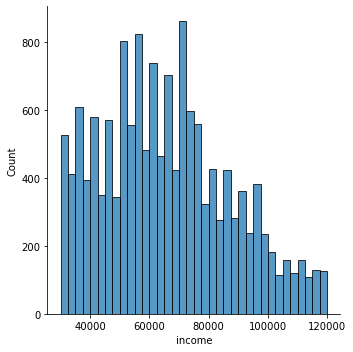

In [30]:
#after data inputation with mean of income
sns.displot(profile.income)

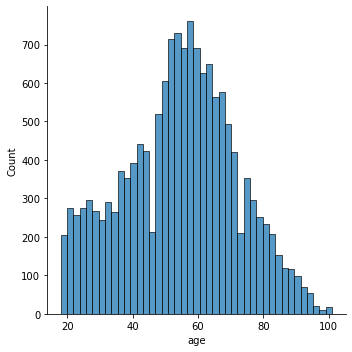

In [31]:
sns.displot(profile.age)

What are the most common promotion?

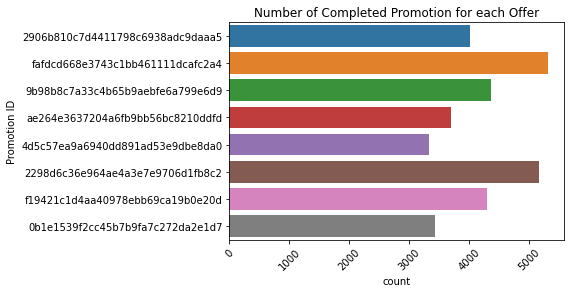

In [32]:
completed_off_count = transcript[transcript['event'] == 'offer completed']

sns.countplot(y=completed_off_count['offer_id'])
plt.title('Number of Completed Promotion for each Offer')
plt.ylabel('Promotion ID')
plt.xticks(rotation = 45)
plt.show();

In [33]:
def get_offer_type(offer_id):
    '''
    input: offer_id: id of offer
    
    output: offer type
    
    '''
    try:
        offer_type = portfolio[portfolio['id'] == offer_id]['offer_type'].values[0]
        return offer_type
    except:
        offer_type = 'NA'
        return offer_type

transcript['offer_type'] = transcript.apply(lambda x: get_offer_type(x['offer_id']), axis=1)

C:\Users\Charles\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


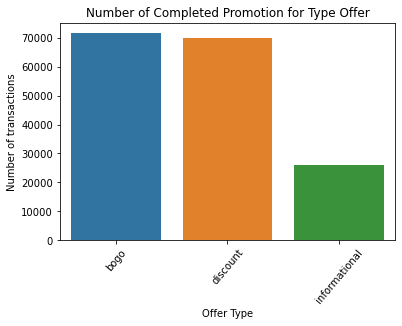

In [34]:
sns.countplot(transcript[transcript['offer_type'] != 'NA']['offer_type'])
plt.title('Number of Completed Promotion for Type Offer')
plt.ylabel('Number of transactions')
plt.xlabel('Offer Type')
plt.xticks(rotation = 50)
plt.show();

In [35]:
profile['age_group'] = pd.cut(profile.age, bins=[0, 12, 18, 21, 64, 200], 
                               labels=['child', 'teen', 'young adult', 'adult', 'elderly'])

In [36]:
loyal_customer_count = transcript[(transcript['event'] == 'offer completed') | (transcript['event'] == 'transaction')].groupby(['person', 'event'])['amount'].sum().reset_index()
loyal_customer_count = loyal_customer_count.sort_values('amount', ascending=False).head(10)
count = 1

for idx, row in loyal_customer_count.iterrows():
    print(f'.------------------- [ #{count} ] ------------------.')
    print(f'| Profile ID: {row["person"]} |')
    print(f'| Number of Completed Offers:       {completed_off_count[(completed_off_count["person"] == row["person"]) & (completed_off_count["event"] == "offer completed")].shape[0]}          |')
    print(f'| Amount:                         ${row["amount"]}        |')
    print(f"'----------------------------------------------'")
    count += 1

.------------------- [ #1 ] ------------------.
| Profile ID: 3c8d541112a74af99e88abbd0692f00e |
| Number of Completed Offers:       5          |
| Amount:                         $1606        |
'----------------------------------------------'
.------------------- [ #2 ] ------------------.
| Profile ID: f1d65ae63f174b8f80fa063adcaa63b7 |
| Number of Completed Offers:       6          |
| Amount:                         $1360        |
'----------------------------------------------'
.------------------- [ #3 ] ------------------.
| Profile ID: ae6f43089b674728a50b8727252d3305 |
| Number of Completed Offers:       3          |
| Amount:                         $1320        |
'----------------------------------------------'
.------------------- [ #4 ] ------------------.
| Profile ID: 626df8678e2a4953b9098246418c9cfa |
| Number of Completed Offers:       4          |
| Amount:                         $1314        |
'----------------------------------------------'
.------------------- [ #

# Multivariate Analysis

1. What are the most popular promotions for each age group?
2. What is the income distribution for each age group?
3. What is the income distribution for each gender?
3. What are the most popular promotions for each gender?

In [37]:
print(portfolio.columns)
print(profile.columns)
print(transcript.columns)

Index(['reward', 'difficulty', 'duration', 'offer_type', 'id', 'social', 'web',
       'email', 'mobile'],
      dtype='object')
Index(['gender', 'age', 'id', 'became_member_on', 'income', 'age_group'], dtype='object')
Index(['person', 'event', 'time', 'offer_id', 'amount', 'reward',
       'offer_type'],
      dtype='object')


In [38]:
print(portfolio.shape)
print(profile.shape)
print(transcript.shape)

(10, 9)
(14825, 6)
(306534, 7)


In [39]:
profile['id'].duplicated().sum() #primary key

0

In [40]:
transcript['person'].duplicated().sum() #not primary key

289534

In [41]:
transcript.shape

(306534, 7)

In [42]:
transcript.drop_duplicates(subset=['person'])

,person,event,time,offer_id,amount,reward,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,bogo
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,discount
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0,0,discount
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0,0,discount
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0,bogo
...,...,...,...,...,...,...,...
213585,9fcbff4f8d7241faa4ab8a9d19c8a812,offer received,504,3f207df678b143eea3cee63160fa8bed,0,0,informational
222411,ebae5093b436466c9fbd097cb7434023,transaction,516,,2,0,NA
249251,912b9f623b9e4b4eb99b6dc919f09a93,offer received,576,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0,bogo
253904,3045af4e98794a04a5542d3eac939b1f,offer received,576,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0,bogo


In [43]:
transcript

,person,event,time,offer_id,amount,reward,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,bogo
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,discount
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0,0,discount
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0,0,discount
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0,bogo
...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,,1,0,NA
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,,9,0,NA
306531,a00058cf10334a308c68e7631c529907,transaction,714,,3,0,NA
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,,3,0,NA


In [44]:
transcript = pd.merge(transcript, profile[['id','age', 'age_group', 'gender','income']], left_on = 'person', right_on = 'id', how = 'left')
transcript

,person,event,time,offer_id,amount,reward,offer_type,id,age,age_group,gender,income
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,bogo,78afa995795e4d85b5d9ceeca43f5fef,75.0,elderly,F,100000.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,discount,NaN,NaN,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0,0,discount,e2127556f4f64592b11af22de27a7932,68.0,elderly,M,70000.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0,0,discount,NaN,NaN,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0,bogo,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,,1,0,NA,b3a1272bc9904337b331bf348c3e8c17,66.0,elderly,M,47000.0
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,,9,0,NA,68213b08d99a4ae1b0dcb72aebd9aa35,52.0,adult,M,62000.0
306531,a00058cf10334a308c68e7631c529907,transaction,714,,3,0,NA,a00058cf10334a308c68e7631c529907,63.0,adult,F,52000.0
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,,3,0,NA,76ddbd6576844afe811f1a3c0fbb5bec,57.0,adult,M,40000.0


In [45]:
profile.shape

(14825, 6)

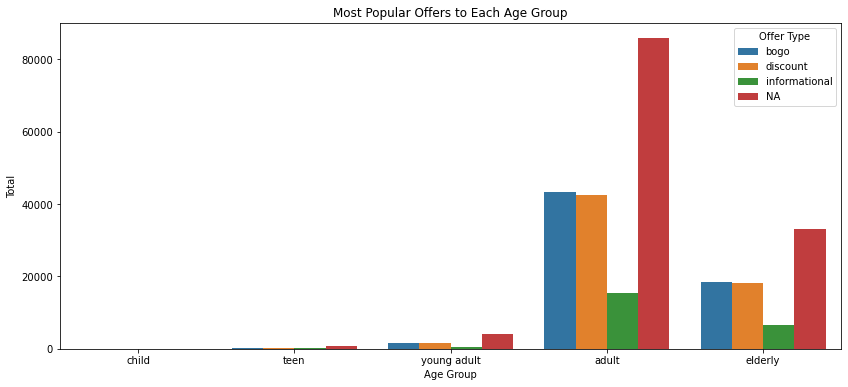

In [46]:
plt.figure(figsize=(14, 6))
sns.countplot(x="age_group", hue="offer_type", data=transcript)
plt.title('Most Popular Offers to Each Age Group')
plt.ylabel('Total')
plt.xlabel('Age Group')
plt.xticks(rotation = 0)
plt.legend(title='Offer Type')
plt.show();

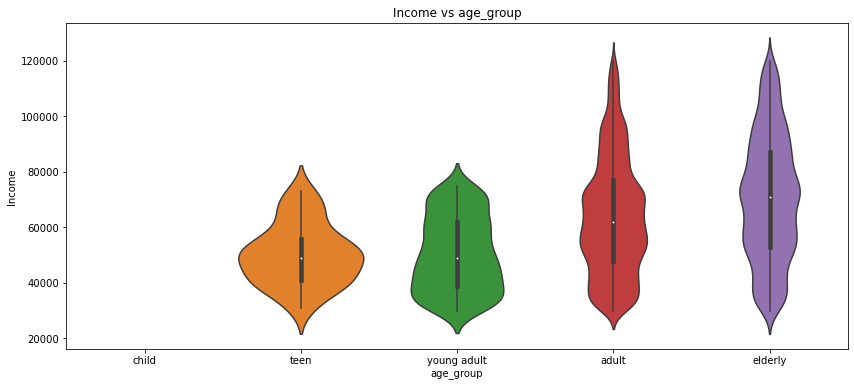

In [47]:
plt.figure(figsize=(14, 6))
sns.violinplot(x=profile[profile['age_group'] != 'NA']['age_group'], y=profile['income'])
plt.title('Income vs age_group')
plt.ylabel('Income')
plt.xlabel('age_group')
plt.xticks(rotation = 0)
plt.show();

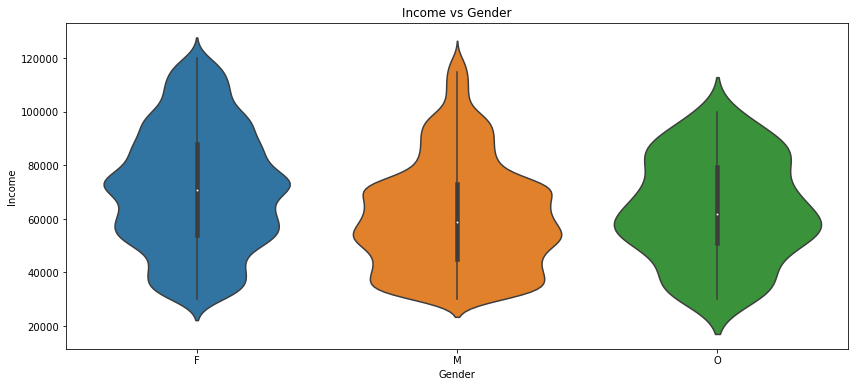

In [48]:
plt.figure(figsize=(14, 6))
sns.violinplot(x=profile[profile['gender'] != 'NA']['gender'], y=profile['income'])
plt.title('Income vs Gender')
plt.ylabel('Income')
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.show();

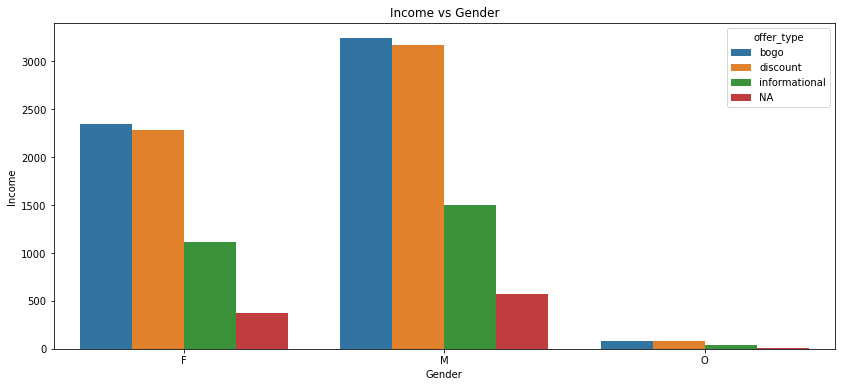

In [49]:
plt.figure(figsize=(14, 6))
sns.countplot(x=profile[profile['gender'] != 'NA']['gender'], hue = 'offer_type', data=transcript)
plt.title('Income vs Gender')
plt.ylabel('Income')
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.show();

# Data Modeling

In [50]:
# The model aims to predict offer_type, I will only get those transcripts with offer id's.
transcript = transcript[transcript['offer_id'] != 'NA']

In [51]:
# Our Features:
# reference: https://www.datacamp.com/community/tutorials/categorical-data

labels_event = transcript['event'].astype('category').cat.categories.tolist()
replace_map_comp_event = {'event' : {k: v for k,v in zip(labels_event,list(range(1,len(labels_event)+1)))}}
print(replace_map_comp_event)

labels_offer_id = transcript['offer_id'].astype('category').cat.categories.tolist()
replace_map_comp_offer_id = {'offer_id' : {k: v for k,v in zip(labels_offer_id,list(range(1,len(labels_offer_id)+1)))}}
print(replace_map_comp_offer_id)

labels_age_group = transcript['age_group'].astype('category').cat.categories.tolist()
replace_map_comp_age_group = {'age_group' : {k: v for k,v in zip(labels_age_group,list(range(1,len(labels_age_group)+1)))}}
print(replace_map_comp_age_group)

labels_gender = transcript['gender'].astype('category').cat.categories.tolist()
replace_map_comp_gender = {'gender' : {k: v for k,v in zip(labels_gender,list(range(1,len(labels_gender)+1)))}}
print(replace_map_comp_gender)

{'event': {'offer completed': 1, 'offer received': 2, 'offer viewed': 3, 'transaction': 4}}
{'offer_id': {'': 1, '0b1e1539f2cc45b7b9fa7c272da2e1d7': 2, '2298d6c36e964ae4a3e7e9706d1fb8c2': 3, '2906b810c7d4411798c6938adc9daaa5': 4, '3f207df678b143eea3cee63160fa8bed': 5, '4d5c57ea9a6940dd891ad53e9dbe8da0': 6, '5a8bc65990b245e5a138643cd4eb9837': 7, '9b98b8c7a33c4b65b9aebfe6a799e6d9': 8, 'ae264e3637204a6fb9bb56bc8210ddfd': 9, 'f19421c1d4aa40978ebb69ca19b0e20d': 10, 'fafdcd668e3743c1bb461111dcafc2a4': 11}}
{'age_group': {'child': 1, 'teen': 2, 'young adult': 3, 'adult': 4, 'elderly': 5}}
{'gender': {'F': 1, 'M': 2, 'O': 3}}


In [52]:
#Out Target:
labels_offer_type = transcript['offer_type'].astype('category').cat.categories.tolist()
replace_map_comp_offer_type = {'offer_type' : {k: v for k,v in zip(labels_offer_type,list(range(1,len(labels_offer_type)+1)))}}
print(replace_map_comp_offer_type)

{'offer_type': {'NA': 1, 'bogo': 2, 'discount': 3, 'informational': 4}}


In [53]:
#Replace categorical with numerical
transcript.replace(replace_map_comp_event, inplace=True)
transcript.replace(replace_map_comp_offer_id, inplace=True)
transcript.replace(replace_map_comp_age_group, inplace=True)
transcript.replace(replace_map_comp_gender, inplace=True)

transcript.replace(replace_map_comp_offer_type, inplace=True)

In [54]:
transcript.head()

,person,event,time,offer_id,amount,reward,offer_type,id,age,age_group,gender,income
0,78afa995795e4d85b5d9ceeca43f5fef,2,0,8,0,0,2,78afa995795e4d85b5d9ceeca43f5fef,75.0,5.0,1.0,100000.0
1,a03223e636434f42ac4c3df47e8bac43,2,0,2,0,0,3,NaN,NaN,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,2,0,4,0,0,3,e2127556f4f64592b11af22de27a7932,68.0,5.0,2.0,70000.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,2,0,11,0,0,3,NaN,NaN,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,2,0,6,0,0,2,NaN,NaN,NaN,NaN,NaN


In [55]:
transcript.shape

(306534, 12)

In [56]:
transcript.dropna(subset=['id'],inplace=True)

transcript.isna().sum()

person        0
event         0
time          0
offer_id      0
amount        0
reward        0
offer_type    0
id            0
age           0
age_group     0
gender        0
income        0
dtype: int64

In [57]:
# Split the data into features and target label
target = transcript['offer_type']
features = transcript.drop(['person', 'offer_type'], axis = 1)

In [58]:
target.head()

0    2
2    3
5    2
7    4
8    3
Name: offer_type, dtype: int64

In [59]:
features.head()

,event,time,offer_id,amount,reward,id,age,age_group,gender,income
0,2,0,8,0,0,78afa995795e4d85b5d9ceeca43f5fef,75.0,5.0,1.0,100000.0
2,2,0,4,0,0,e2127556f4f64592b11af22de27a7932,68.0,5.0,2.0,70000.0
5,2,0,10,0,0,389bc3fa690240e798340f5a15918d5c,65.0,5.0,2.0,53000.0
7,2,0,5,0,0,2eeac8d8feae4a8cad5a6af0499a211d,58.0,4.0,2.0,51000.0
8,2,0,2,0,0,aa4862eba776480b8bb9c68455b8c2e1,61.0,4.0,1.0,57000.0


Normalising numerical values (time, amount, reward and income) because we use them as features for the model

In [60]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
to_normalize = ['time', 'amount', 'reward', 'income']

features[to_normalize] = scaler.fit_transform(features[to_normalize])
features.head()

,event,time,offer_id,amount,reward,id,age,age_group,gender,income
0,2,0.0,8,0.0,0.0,78afa995795e4d85b5d9ceeca43f5fef,75.0,5.0,1.0,0.777778
2,2,0.0,4,0.0,0.0,e2127556f4f64592b11af22de27a7932,68.0,5.0,2.0,0.444444
5,2,0.0,10,0.0,0.0,389bc3fa690240e798340f5a15918d5c,65.0,5.0,2.0,0.255556
7,2,0.0,5,0.0,0.0,2eeac8d8feae4a8cad5a6af0499a211d,58.0,4.0,2.0,0.233333
8,2,0.0,2,0.0,0.0,aa4862eba776480b8bb9c68455b8c2e1,61.0,4.0,1.0,0.300000


In [61]:
features.drop(columns=['id'], inplace = True)

__Create training and test sets__

In [62]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=0)

print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (204571, 9)
Training Labels Shape: (204571,)
Testing Features Shape: (68191, 9)
Testing Labels Shape: (68191,)


# Metrics

Accuracy will be used for model evaluation. It is the ratio of correctly labeled subjects to the whole pool of subjects. 

Accuracy = (TP+TN)/(TP+FP+FN+TN)

Since this is a simple classification problem, accuracy is an appropriate way to evaluate the model

In [63]:
# reference: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
def pred_score(model):
    pred = model.predict(X_test)
    # Calculate the absolute errors
    errors = abs(pred - y_test)
    # Calculate mean absolute percentage error
    mape = 100 * (errors / y_test)
    accuracy = 100 - np.mean(mape)
    return round(accuracy, 2)

__1. Logistic Regression__

In [64]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

logreg.fit(X_train, y_train)
print(f'Accuracy of Logistic regression classifier on training set: {round(logreg.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {pred_score(logreg)}%')

Accuracy of Logistic regression classifier on training set: 79.73%.
Prediction Accuracy: 92.24%


C:\Users\Charles\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


__2. K-Nearest Neighbors__

In [65]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

knn.fit(X_train, y_train)
print(f'Accuracy of K-NN classifier on training set: {round(knn.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {pred_score(knn)}%')

Accuracy of K-NN classifier on training set: 100.0%.
Prediction Accuracy: 99.99%


__3. Decision Tree__

In [66]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()

dt.fit(X_train, y_train)
print(f'Accuracy of Decision Tree classifier on training set: {round(dt.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {pred_score(dt)}%')

Accuracy of Decision Tree classifier on training set: 100.0%.
Prediction Accuracy: 100.0%


__4. Support Vector Machine__

In [67]:
from sklearn.svm import SVC

svm = SVC()

svm.fit(X_train, y_train)
print(f'Accuracy of SVM classifier on training set: {round(svm.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {pred_score(svm)}%')

Accuracy of SVM classifier on training set: 85.07%.
Prediction Accuracy: 93.63%


__5. Random Forest__

In [68]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import f1_score

rf = RandomForestRegressor(n_estimators = 100, random_state = 42)

rf.fit(X_train, y_train)
print(f'Accuracy of SVM classifier on training set: {round(rf.score(X_train, y_train)*100,2)}%.')
y_pred = rf.predict(X_test)
print(f1_score(y_test, y_pred, average="macro"))

Accuracy of SVM classifier on training set: 100.0%.
1.0


__6. Naive Bayes__

In [69]:
from sklearn.naive_bayes import GaussianNB 

gnb = GaussianNB() 
gnb.fit(X_train, y_train) 
print(f'Accuracy of SVM classifier on training set: {round(gnb.score(X_train, y_train)*100,2)}%.')
y_pred = rf.predict(X_test)
print(f1_score(y_test, y_pred, average="macro"))

Accuracy of SVM classifier on training set: 95.12%.
1.0


# Models Results

In [70]:
# reference: https://stackoverflow.com/a/52768022
models = [logreg, knn, dt, svm, rf, gnb]
model_names = [type(n).__name__ for n in models]
tr_accuracy = [x.score(X_train, y_train)*100 for x in models]
pred_accuracy = [pred_score(y) for y in models]

In [71]:
results = [tr_accuracy, pred_accuracy]
results_df = pd.DataFrame(results, columns = model_names, index=['Training Accuracy', 'Predicting Accuracy']) 
results_df

,LogisticRegression,KNeighborsClassifier,DecisionTreeClassifier,SVC,RandomForestRegressor,GaussianNB
Training Accuracy,79.730754,99.998045,100.0,85.072175,100.0,95.122965
Predicting Accuracy,92.240000,99.990000,100.0,93.630000,100.0,95.190000


# Model Improvements

In [72]:
# Tuning to improve accuracy
dual = [True, False]
max_iter = [100, 120, 140, 160, 180, 200, 220]
C = [1.0,1.5,2.0,2.5,3.0,3.5,4.0]
param_grid = dict(dual = dual, max_iter = max_iter, C = C)

lr = LogisticRegression(random_state=42)
grid = GridSearchCV(estimator = lr, param_grid = param_grid, cv = 3, n_jobs = -1)
grid_result = grid.fit(X_train, y_train)

print(f'Best Score: {grid_result.best_score_}')
print(f'Best params: {grid_result.best_params_}')

Best Score: 0.7970288931497427
Best params: {'C': 3.0, 'dual': False, 'max_iter': 100}


C:\Users\Charles\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Conclusion

In this project, transaction, demographic and offer data are used to determine demographic groups response to offer type and thereby predict the best offer to give to a particular customer. Firstly, I did exploratory data analysis by answering some of the key questions, and conducted data preprocessing like data inputation for missing values, and normalisation of numerical values. From the analysis, it is apparant that females are more responsive to promotion than males since they have more completed offers. BOGO and Discount offers are also more popular promotions among the Starbucks customers.


# Improvements

Ways to improve the prediction accuracy would be to create a better data collection process that reduces the number NaN values. It might be useful to have other variables like the location/store of the transaction, weather during the time or purchase, time of the day, day of the year and other seasonality factors that could potentially improve the model prediction and thereby increasing the effectiveness of the offer targeted to different groups of people.